#Identifying Diffusion / Advection-Diffusion from Trajectory
In this notebook we demonstrate the method for finding the PDE associated with the distribution of a particle with stochastic trajectory. The advection-diffusion equation is derived from a single biased random walk trajectory using DeepMoD

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import sys
import os
import copy

sys.path.append('../src/deepymod/')

from scipy.io import loadmat
from DeepMoD import DeepMoD
from library_functions import library_2Din_1Dout
from deepymod.utilities import library_matrix_mat, print_PDE

plt.style.use('seaborn')

import seaborn as sns; sns.set(style="white", color_codes=True)

##Generating Trajectory
First we generate a biased random walk trajectory. This is just a bunch of points where each is drawn from a normal distribution centered on it's predecesor, which moves in the direction of the bias (if any) at each time step i.e $x_{n+1}=\mathcal{N}(x_n+vdt,\sqrt{2Ddt})$, where $D$ is the Diffusion constant, $v$ is the bias or the velocity and $dt$ is the time step. For the sake of this exercise we fix the total number of timesteps at $10^5$.  We also set $D=2$, $v=0$ and $dt=0.01$. So the associated Diffusion equation will be,

 $$\frac{\partial u}{\partial t}=2\frac{\partial^2 u}{\partial x^2}$$


In [2]:
length = 10**5 #Length of Time Series
dt = 0.01      #Time Step
D = 2          #Diffusion Constant
v = 0          #Velocity (v=0  for simple diffusion)


In [3]:
pos = np.cumsum(np.sqrt(2*D*dt)*np.random.randn(length)) + v*dt*np.arange(length) #Position of the random walker
time=dt*np.arange(length)

Text(0.5, 1.0, 'Single trajectory of a particle undergoing Brownian Motion')

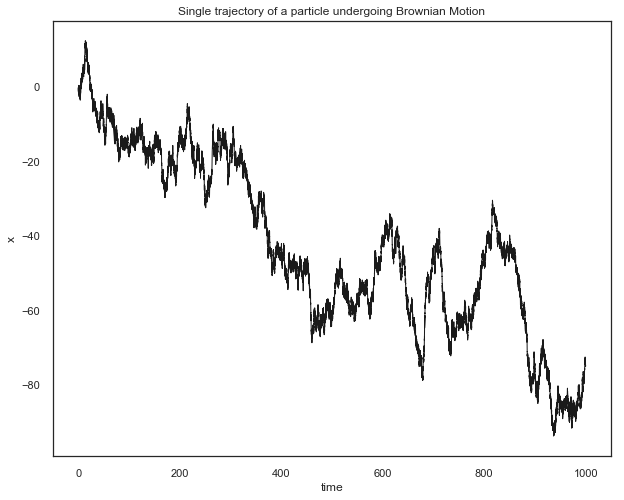

In [4]:
plt.figure(figsize=(10,8))
plt.plot(time,pos,'k-',linewidth=1)
plt.xlabel('time')
plt.ylabel('x')
plt.title('Single trajectory of a particle undergoing Brownian Motion')

##Finding the distribution function
Now we take the single trajectory, split it up into many smaller ones, and create a histogram to approximate the distribution funciton. We take the first $10$ time steps and generate $300$ bins for each time point. So we have generated $3000$ spatiotemporal datapoints.

In [5]:
P = {}
M = 0

m = 10     # no of time points where we want to map the distrubution
n = 300    # no of bins used in the distribution

#######


#pos = data_add

for i in range(m):
    P[i] = []
    
for i in range(len(pos)-m):
    # center
    y = pos[i+1:i+m+1] - pos[i]
    M = max([M, max(abs(y))])
   
    # add to distribution
    for j in range(m):
        P[j].append(y[j])
        
        

In [6]:
bins = np.linspace(-M,M,n+1)             
x = np.linspace(M*(1/n-1),M*(1-1/n),n)
dx = x[2]-x[1]

#########
#dt = 1/6  #in hr
#########

time=dt*np.arange(length)

T = np.linspace(0,dt*(m-1),m)
U = np.zeros((n,m))

##Visualising the distribution function obtained
We see that the histograms clearly indicate normal distributions which spreads and also moves towards the right with time. 

In [7]:
for i in range(m):
    U[:,i] = np.histogram(P[i],bins,)[0]/float(dx*(len(pos)-m))

Text(0.5, 1.0, 'Histograms for $f(x,t)$')

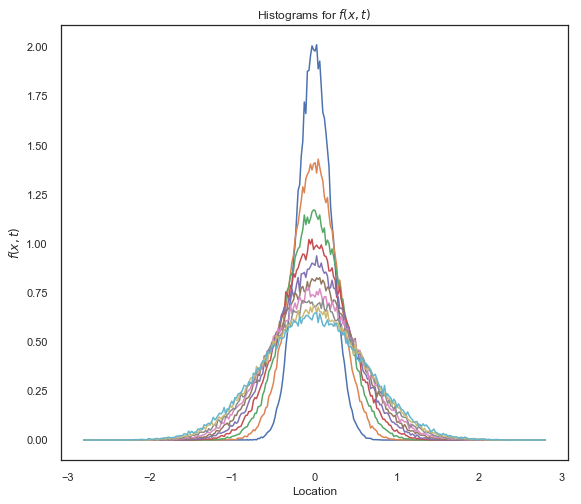

In [8]:
########

plt.figure(figsize=(20,8))

plt.subplot(121)
for j in range(m):
  plt.plot(x,U[:,j],label ='t = %.2f'%(j*dt+dt))

plt.xlabel('Location')
plt.ylabel(r'$f(x,t)$')
plt.title(r'Histograms for $f(x,t)$')

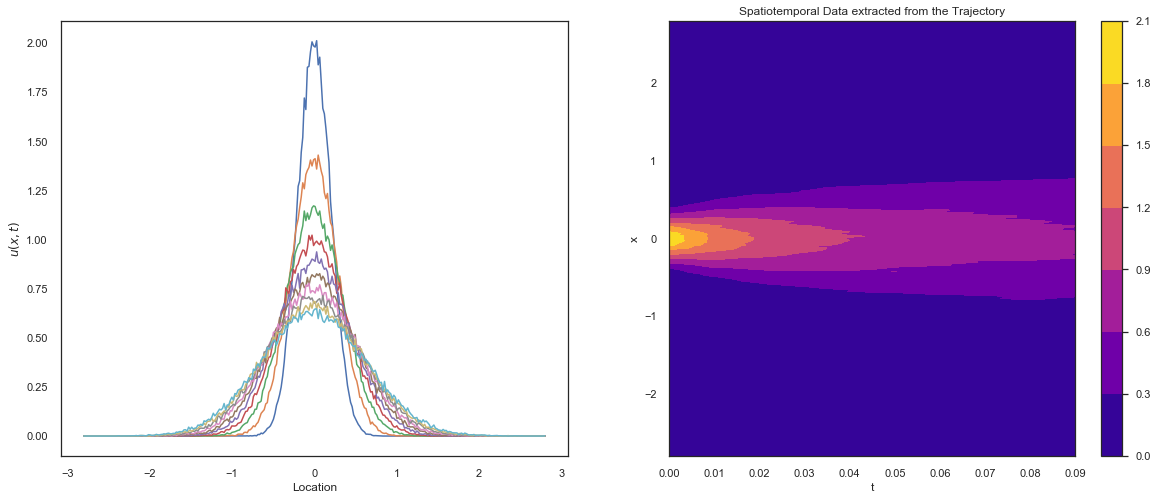

In [9]:
############

x_trunc = x
T_trunc = T
U_trunc = U


plt.figure(figsize=(20,8))

plt.subplot(121)
for j in range(len(T_trunc)):
  plt.plot(x_trunc,U_trunc[:,j],label ='t = %.2f'%(j*dt+dt))

plt.xlabel('Location')
plt.ylabel(r'$u(x,t)$')
#plt.title(r'Histograms for $f(x,t)$')
#plt.legend(loc = 'upper right')

x_grid, t_grid = np.meshgrid(x_trunc, T_trunc, indexing='ij')

plt.subplot(122)
plt.contourf(T_trunc,x_trunc,U_trunc,cmap='plasma')
plt.colorbar()
plt.xlabel('t')
plt.ylabel('x')
plt.title('Spatiotemporal Data extracted from the Trajectory')
plt.show()

We make the data 'machine learning'-friendly by flattening both the input features and output in a seperate matrices.

In [10]:
X = np.transpose((x_grid.flatten(), t_grid.flatten()))
y = U_trunc.reshape((U_trunc.size, 1))

##Architecture
We define the architecture of our Neural Net. We use 6 hidden layers with 20 neurons each.

We randomize our data sets to avoid fitting of spurious correlations from sequential data.

In [13]:
int(y.size)

3000

In [23]:
idx = np.random.choice(y.size, y.size)
split = [2000]

X_train, X_test = np.vsplit(X[idx, :], split)
y_train, y_test = np.vsplit(y[idx,:], split)


In [24]:
print("Number of data points being used -", y_train.size )

Number of data points being used - 2000


In [30]:
def library_1D(data, prediction, library_config):
    '''
    Constructs a library graph in 1D. Library config is dictionary with required terms.
    '''

    # Polynomial
    u = tf.ones_like(prediction)

    for order in np.arange(1, library_config['poly_order']+1):
        u = tf.concat((u, u[:, order-1:order]*prediction), axis=1)
    u = tf.expand_dims(u, axis=2)

    # Gradients
    dy = tf.gradients(prediction, data)[0]
    y_t = dy[:, 1:2]
    y_x = dy[:, 0:1]
    
    dtt = tf.gradients(y_t,data)[0]
    
    y_tt = dtt[:, 1:2]
    
    dyy = tf.gradients(y_x, data)[0]
    
    y_xx = dyy[:, 0:1]
    
    dyyy = tf.gradients(y_xx, data)[0]
    
    y_xxx = dyyy[:, 0:1]
    

    du = tf.concat((tf.ones_like(y_t), y_tt, y_x, y_xx, y_xxx), axis=1)
    
    
    #for order in np.arange(2, library_config['deriv_order']+1):
    #    du = tf.concat((du, tf.gradients(du[:, order-1], data)[0][:, 0:1]), axis=1)
    du = tf.expand_dims(du, axis=1)

    # Bringing it together
    theta = tf.matmul(u, du)
    theta = tf.reshape(theta, [tf.shape(theta)[0], tf.size(theta[0, :, :])])

    return [y_t], theta

##Running DeepMoD

In [31]:
u = ['1', 'u', 'uˆ2']
du = ['1', 'u_{t}', 'u_{x}', 'u_{xx}','u_{xxx}']
coeffs_list = library_matrix_mat(u, du)

print(coeffs_list)

library_config = {'total_terms': len(coeffs_list), 'deriv_order': 3, 'poly_order': 2}

['1', 'u_{t}', 'u_{x}', 'u_{xx}', 'u_{xxx}', 'u', 'uu_{t}', 'uu_{x}', 'uu_{xx}', 'uu_{xxx}', 'uˆ2', 'uˆ2u_{t}', 'uˆ2u_{x}', 'uˆ2u_{xx}', 'uˆ2u_{xxx}']


In [32]:
n = 20
config = {'layers': [2, n, n, n, n, 1], 'lambda': 10e-5}
train_opts = {'max_iterations': 50000, 'grad_tol':10**-6, 'learning_rate': 0.0025, 'beta1': 0.99, 'beta2': 0.999, 'epsilon': 10**-8}
output_opts = {'output_directory': 'output/SPT/Diffusion_1000', 'X_predict': X}

In [ ]:
sparse_vectors = DeepMoD(X_train, y_train, config, library_1D, library_config, train_opts,output_opts)

Epoch | Total loss | Loss gradient | MSE | PI | L1 
0 [0.6087158, 0.011751654, 0.12463162, 0.4822306, 0.0018535419]
500 [0.0567944, 0.04391894, 0.046667952, 0.009948171, 0.00017827794]
1000 [0.019012524, 0.0048176697, 0.01573111, 0.0026418557, 0.0006395597]
1500 [0.013176724, 0.0016206965, 0.012660955, 0.00015223166, 0.00036353758]
2000 [0.012813594, 0.00095668546, 0.012489048, 6.7773806e-05, 0.00025677256]
2500 [0.012431325, 0.0006902368, 0.012235225, 3.2186494e-05, 0.00016391334]
3000 [0.01181581, 0.0008458992, 0.011547382, 8.795989e-05, 0.00018046751]
3500 [0.010862001, 0.0011641359, 0.010474007, 0.00019965359, 0.00018834119]
4000 [0.009642557, 0.0012488284, 0.009095704, 0.00038488777, 0.0001619652]
4500 [0.0073925266, 0.003888428, 0.006687349, 0.0005044639, 0.00020071364]
5000 [0.006202504, 0.018001385, 0.005702612, 0.00033044576, 0.00016944627]
5500 [0.004689089, 0.021172065, 0.0043123914, 0.00019894792, 0.00017775012]
6000 [0.003774702, 0.012463418, 0.0034403505, 0.00016751752, 0

In [25]:
def library_1D_lim(data, prediction, library_config):
    '''
    Constructs a library graph in 1D. Library config is dictionary with required terms.
    '''

    # Polynomial
    u = tf.ones_like(prediction)

    for order in np.arange(1, library_config['poly_order']+1):
        u = tf.concat((u, u[:, order-1:order]*prediction), axis=1)
    u = tf.expand_dims(u, axis=2)

    # Gradients
    dy = tf.gradients(prediction, data)[0]
    y_t = dy[:, 1:2]
    y_x = dy[:, 0:1]
    
    #dtt = tf.gradients(y_t,data)[0]
    #y_tt = dtt[:, 1:2]
    
    
    dyy = tf.gradients(y_x, data)[0]
    y_xx = dyy[:, 0:1]
    
    du = tf.concat((tf.ones_like(y_x), y_x, y_xx), axis=1)
    du = tf.expand_dims(du, axis=1)

    # Bringing it together
    theta = tf.matmul(u, du)
    theta = tf.reshape(theta, [tf.shape(theta)[0], tf.size(theta[0, :, :])])

    return [y_t], theta

#Results

In [ ]:
print('Inferred equation:')
print_PDE(sparse_vectors[0], coeffs_list, PDE_term='u_t')

Inferred equation:
u_t = 1.652u_{xx} - 2.741uu_{x}


In [ ]:
def PINN_graph(config, library_function, library_config):
    tf.reset_default_graph()
    # Creating datasets
    with tf.name_scope("Defining_variables"):
        data_feed = tf.placeholder(tf.float32, shape=[None, config['layers'][0]])
        target_feed = tf.placeholder(tf.float32, shape=[None, config['layers'][-1]])
        mask_feed = tf.placeholder(tf.int32, shape=[None, config['layers'][-1]])

        lambda_L1 = tf.constant(config['lambda'], tf.float32)

        coeff_list = [tf.Variable(config['initial_coeffs'][output_neuron], dtype=tf.float32) for output_neuron in np.arange(config['layers'][-1])]

    with tf.name_scope("Data_pipeline"):
        mask = tf.ones([tf.size(target_feed[:, 0:1]), tf.shape(mask_feed)[0], tf.shape(mask_feed)[1]], dtype=tf.int32) * tf.expand_dims(mask_feed, axis=0)

        dataset = tf.data.Dataset.from_tensor_slices((data_feed, target_feed, mask)).repeat().batch(tf.shape(data_feed, out_type=tf.int64)[0])

        iterator = dataset.make_initializable_iterator()
        data, target, sparsity_mask = iterator.get_next()

    # The actual network
    with tf.name_scope("Neural_Network"):
        X = data
        for layer in np.arange(len(config['layers'])-2):
            X = tf.layers.dense(X, units=config['layers'][layer+1], activation=tf.nn.tanh, kernel_initializer=tf.constant_initializer(config['initial_weights'][layer]), bias_initializer=tf.constant_initializer(config['initial_biases'][layer]))
        prediction = tf.layers.dense(inputs=X, units=config['layers'][-1], activation=None, kernel_initializer=tf.constant_initializer(config['initial_weights'][-1]), bias_initializer=tf.constant_initializer(config['initial_biases'][-1]))

    # make library according to supplied function
    with tf.name_scope("Creating_library"):
        time_deriv_list, theta = library_function(data, prediction, library_config)
        theta_split = [tf.dynamic_partition(theta, coeff_mask, 2)[1] for coeff_mask in tf.unstack(sparsity_mask, axis=2, num=len(coeff_list))]
        sparse_thetas_list = [tf.reshape(sparse_theta, [tf.shape(theta)[0], tf.size(coeff)]) for coeff, sparse_theta in zip(coeff_list, theta_split)]

    # Normalizing
    with tf.name_scope("Scaling"):
        scaling_time = [tf.norm(time_deriv, axis=0) for time_deriv in time_deriv_list]
        scaling_theta = [tf.expand_dims(tf.norm(sparse_theta, axis=0), axis=1) for sparse_theta in sparse_thetas_list]
        coeff_scaled_list = [coeff * (theta_scale / time_scale) for coeff, theta_scale, time_scale in zip(coeff_list, scaling_theta, scaling_time)]

    # Defining cost function
    with tf.name_scope("Cost_MSE"):
        MSE_costs = tf.reduce_mean(tf.square(target - prediction), axis=0)
        cost_MSE = tf.reduce_mean(MSE_costs)

    with tf.name_scope("Cost_PI"):
        PI_costs = [tf.reduce_mean(tf.square(tf.matmul(sparse_theta, coeff) - time_deriv)) for sparse_theta, coeff, time_deriv in zip(sparse_thetas_list, coeff_list, time_deriv_list)]
        cost_PI = tf.reduce_sum(PI_costs)

    with tf.name_scope('Cost_L1'):
        L1_costs = [lambda_L1 * tf.reduce_sum(tf.abs(coeff[1:, :])) for coeff in coeff_scaled_list]
        cost_L1 = tf.reduce_sum(L1_costs)

    with tf.name_scope("Total_cost"):
        loss = cost_MSE + cost_PI + cost_L1

    # graph node for gradient
    with tf.name_scope("GradLoss"):
        grad_losses = [tf.reduce_max(tf.abs(tf.gradients(loss, coeff)[0]) / (theta_scale / time_scale)) for coeff, theta_scale, time_scale in zip(coeff_list, scaling_theta, scaling_time)]
        gradloss = tf.reduce_max(grad_losses)

    return AttrDict(locals())

def inference_graph(data, weights, biases, layers, batchsize=1000):
    dataset = tf.data.Dataset.from_tensor_slices(data).batch(batchsize)
    iterator = dataset.make_one_shot_iterator()
    data = iterator.get_next()

    X = data
    for layer in np.arange(len(layers)-2):
        X = tf.layers.dense(X, units=layers[layer+1], activation=tf.nn.tanh, kernel_initializer=tf.constant_initializer(weights[layer]), bias_initializer=tf.constant_initializer(biases[layer]))
    prediction = tf.layers.dense(inputs=X, units=layers[-1], activation=None, kernel_initializer=tf.constant_initializer(weights[-1]), bias_initializer=tf.constant_initializer(biases[-1]))

    return AttrDict(locals())

class AttrDict(dict):
    __getattr__ = dict.__getitem__
__setattr__ = dict.__setitem__

In [ ]:
def PINN(data, target, mask, config, library_function, library_config, train_opts):
    # Defining graph, optimizer and feed_dict
    graph = PINN_graph(config, library_function, library_config)

    train_op = tf.train.AdamOptimizer(learning_rate=train_opts['learning_rate'], beta1=train_opts['beta1'], beta2=train_opts['beta2'], epsilon=train_opts['epsilon']).minimize(graph.loss)

    feed_dict = {graph.data_feed: data, graph.target_feed: target, graph.mask_feed: mask}

    # Running the fitting procedure
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer(), feed_dict=feed_dict)
        sess.run(graph.iterator.initializer, feed_dict=feed_dict)

        #writer = tf.summary.FileWriter(os.path.join(output_opts['output_directory'], "iteration_" + str(output_opts['cycles'])))
        #writer.add_graph(sess.graph)
        #merged_summary, custom_board = tb_setup(graph, output_opts)
        #writer.add_summary(custom_board)

        print('Epoch | Total loss | Loss gradient | MSE | PI | L1 ')
        for iteration in np.arange(train_opts['max_iterations']):
            sess.run(train_op)
            #if iteration % 50 == 0:
            #    summary = sess.run(merged_summary)
            #    writer.add_summary(summary, iteration)
            if iteration % 500 == 0:
                print(iteration, sess.run([graph.loss, graph.gradloss, graph.cost_MSE, graph.cost_PI, graph.cost_L1]))
                if sess.run(graph.gradloss) < train_opts['grad_tol']:
                    print('Optimizer converged.')
                    break
          

        coeff_list = [map_to_sparse_vector(coeff_mask, coeff) for coeff_mask, coeff in zip(np.split(mask, mask.shape[1], axis=1), sess.run(graph.coeff_list))]
        coeff_scaled_list = [map_to_sparse_vector(coeff_mask, coeff) for coeff_mask, coeff in zip(np.split(mask, mask.shape[1], axis=1), sess.run(graph.coeff_scaled_list))]

        weights_biases = sess.run(tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES))[len(coeff_list):]
        weights = weights_biases[::2]
        biases = weights_biases[1::2]

    return coeff_list, coeff_scaled_list, weights, biases

def inference(data, weights, biases, layers, batchsize=1000):
    graph = inference_graph(data, weights, biases, layers, batchsize=batchsize)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
    
        prediction = [sess.run(graph.prediction) for batch in np.arange(np.ceil(data.shape[0]/batchsize))]
        prediction = np.concatenate(prediction, axis=0)

    return prediction


def map_to_sparse_vector(mask, coeff):
    sparse_vec = np.zeros_like(mask, dtype=np.float)
    sparse_vec[np.where(mask)[0]] = coeff

    return sparse_vec

In [ ]:


'''
This file contains several ready-to-use library functions.
'''


def library_2Din_1Dout(data, prediction, library_config):
        '''
        Constructs a library graph in 1D. Library config is dictionary with required terms.
        '''

        # Polynomial
        u = tf.ones_like(prediction)

        for order in np.arange(1, library_config['poly_order']+1):
            u = tf.concat((u, u[:, order-1:order]*prediction), axis=1)
        u = tf.expand_dims(u, axis=2)

        # Gradients
        du = tf.gradients(prediction, data)[0]
        u_t = du[:, 0:1]
        u_x = du[:, 1:2]
        u_y = du[:, 2:3]
        du2 = tf.gradients(u_x,data)[0]
        u_xx = du2[:, 1:2]
        u_xy = du2[:, 2:3]
        u_yy = tf.gradients(u_y,data)[0][:, 2:3]
        du = tf.concat((tf.ones_like(u_x), u_x, u_y , u_xx, u_yy, u_xy), axis=1)
        #for order in np.arange(2, library_config['deriv_order']+1):
        #    du = tf.concat((du, tf.gradients(du[:, order-1], data)[0][:, 0:1]), axis=1)
        du = tf.expand_dims(du, axis=1)

        # Bringing it together
        theta = tf.matmul(u, du)
        theta = tf.reshape(theta, [tf.shape(theta)[0], tf.size(theta[0, :, :])])

        return [u_t], theta


def library_2Din_2Dout(data, prediction, library_config):

    #Polynomial in u
    u = tf.ones_like(prediction[:, 0:1])

    for order in np.arange(1, library_config['poly_order']+1):
        u = tf.concat((u, u[:, order-1:order]*prediction[:, 0:1]), axis=1)
    u = tf.expand_dims(u, axis=2)

    print(u.shape)

    # Polynomial in v
    v = tf.ones_like(prediction[:, 1:2])

    for order in np.arange(1, library_config['poly_order']+1):
        v = tf.concat((v, v[:, order-1:order]*prediction[:, 1:2]), axis=1)
    v = tf.expand_dims(v, axis=1)

    print(v.shape)
    # Calculating all cross terms
    uv = tf.matmul(u, v)
    uv = tf.reshape(uv, [tf.shape(u)[0], tf.size(uv[0, :, :])])
    uv = tf.expand_dims(uv,axis=2)


    print(uv.shape)
    # Derivative in u
    du = tf.gradients(prediction[:, 0:1], data)[0]
    u_t = du[:, 0:1]
    u_x = du[:, 1:2]
    u_y = du[:, 2:3]
    du2 = tf.gradients(u_x, data)[0]
    u_xx = du2[:, 1:2]
    u_xy = du2[:, 2:3]
    u_yy = tf.gradients(u_y, data)[0][:, 2:3]
    du = tf.concat((u_x, u_y , u_xx, u_yy, u_xy), axis=1)
    print(du.shape)
    # Derivative in v
    dv = tf.gradients(prediction[:, 1:2], data)[0]
    v_t = dv[:, 0:1]
    v_x = dv[:, 1:2]
    v_y = dv[:, 2:3]
    dv2 = tf.gradients(v_x, data)[0]
    v_xx = dv2[:, 1:2]
    v_xy = dv2[:, 2:3]
    v_yy = tf.gradients(v_y,data)[0][:, 2:3]
    dv = tf.concat((v_x, v_y , v_xx, v_yy, v_xy), axis=1)
    print(dv.shape)
    # Bringing du and dv together and calculating cross terms
    dudv = tf.concat((tf.ones_like(v_x), du, dv), axis=1)
    dudv = tf.expand_dims(dudv, axis=1)
    theta = tf.matmul(uv, dudv)
    theta = tf.reshape(theta, [tf.shape(theta)[0], tf.size(theta[0, :, :])])

    time_deriv = [u_t, v_t]

    return time_deriv, theta

def library_2Din_2Dout_lim(data, prediction, library_config):

    #Polynomial in u
    u = tf.ones_like(prediction[:, 0:1])

    for order in np.arange(1, library_config['poly_order']+1):
        u = tf.concat((u, u[:, order-1:order]*prediction[:, 0:1]), axis=1)
    u = tf.expand_dims(u, axis=2)


    # Polynomial in v
    v = tf.ones_like(prediction[:, 1:2])

    for order in np.arange(1, library_config['poly_order']+1):
        v = tf.concat((v, v[:, order-1:order]*prediction[:, 1:2]), axis=1)
    v = tf.expand_dims(v, axis=1)


    # Calculating all cross terms
    uv = tf.matmul(u, v)
    uv = tf.reshape(uv, [tf.shape(u)[0], tf.size(uv[0, :, :])])
    uv = tf.expand_dims(uv,axis=2)

    # Derivative in u
    du = tf.gradients(prediction[:, 0:1], data)[0]
    u_t = du[:, 0:1]
    u_x = du[:, 1:2]
    u_y = du[:, 2:3]
    du2 = tf.gradients(u_x, data)[0]
    u_xx = du2[:, 1:2]
    u_yy = tf.gradients(u_y, data)[0][:, 2:3]
    du = tf.concat((u_xx, u_yy), axis=1)

    # Derivative in v
    dv = tf.gradients(prediction[:, 1:2], data)[0]
    v_t = dv[:, 0:1]
    v_x = dv[:, 1:2]
    v_y = dv[:, 2:3]
    dv2 = tf.gradients(v_x, data)[0]
    v_xx = dv2[:, 1:2]
    v_yy = tf.gradients(v_y,data)[0][:, 2:3]
    dv = tf.concat((v_xx, v_yy), axis=1)

    # Bringing du and dv together and calculating cross terms
    dudv = tf.concat((tf.ones_like(v_x), du, dv), axis=1)
    dudv = tf.expand_dims(dudv, axis=1)
    theta = tf.matmul(uv, dudv)
    theta = tf.reshape(theta, [tf.shape(theta)[0], tf.size(theta[0, :, :])])

    time_deriv = [u_t, v_t]

    return time_deriv, theta

def library_1Din_2Dout_chemo(data, prediction, library_config):
    #Polynomial in u
    
    u = tf.ones_like(prediction[:, 0:1])
    for order in np.arange(1, library_config['poly_order']+1):
        u = tf.concat((u, u[:, order-1:order]*prediction[:, 0:1]), axis=1)
    u = tf.expand_dims(u, axis=2)

    print("u",u.shape)
    
    # Polynomial in v
    
    v = tf.ones_like(prediction[:, 1:2])
    for order in np.arange(1, library_config['poly_order']+1):
        v = tf.concat((v, v[:, order-1:order]*prediction[:, 1:2]), axis=1)
    v = tf.expand_dims(v, axis=1)

    print("v",v.shape)      
    
    # Derivative in u
    du = tf.gradients(prediction[:, 0:1], data)[0]
    u_t = du[:, 1:2]
    u_x = du[:, 0:1]
    
    du2 = tf.gradients(u_x, data)[0]
    u_xx = du2[:, 0:1]

    du = tf.concat((u_x,u_xx),axis=1)
    print("du",du.shape)
    
    # Derivative in v
    dv = tf.gradients(prediction[:, 1:2], data)[0]
    v_t = dv[:, 1:2]
    v_x = dv[:, 0:1]

    dv2 = tf.gradients(v_x, data)[0]
    v_xx = dv2[:, 0:1]
    
    dv=tf.concat((v_x, v_xx),axis=1)
    print("dv",dv.shape)
     
    #Calculating all cross derivative terms
    Du = du
    Dv = dv
    
    Du = tf.expand_dims(Du, axis=2)
    Dv = tf.expand_dims(Dv, axis=1)
    
    Ddudv = tf.matmul(Du,Dv)
    Ddudv = tf.reshape(Ddudv, [tf.shape(Ddudv)[0], tf.size(Ddudv[0, :, :])])
    
    # Calculating all cross terms
    
    uv = tf.matmul(u, v)
    uv = tf.reshape(uv, [tf.shape(u)[0], tf.size(uv[0, :, :])])
    uv = tf.expand_dims(uv,axis=2)

    print("uv",uv.shape)
    print("Ddudv",Ddudv.shape)
    
    # Bringing du and dv together and calculating cross terms
    dudv = tf.concat((tf.ones_like(v_x), du, dv, Ddudv), axis=1)
    
    print("dudv",dudv.shape)
    
    dudv = tf.expand_dims(dudv, axis=1)
    theta = tf.matmul(uv, dudv)
    theta = tf.reshape(theta, [tf.shape(theta)[0], tf.size(theta[0, :, :])])

    time_deriv = [u_t, v_t]

    return time_deriv, theta



In [ ]:
def library_matrix_mat(u, v, latex=False):
    '''
    Implements the matrix multiplication for strings and flattens it,
    mimicking how the library is made.
    Set latex=True to obtain latex forms.
    '''
    comp_list = []
    for u_element in u:
        for v_element in v:
            if ((u_element == '1') and ('v_element' == '1')):
                result = '1'
            elif u_element == '1':
                result = v_element
            elif v_element == '1':
                result = u_element
            else:
                result = u_element + v_element
            comp_list.append(result)
    if latex is True:
        comp_list = list(map(lambda x: '$'+x+'$', comp_list))
    return comp_list


def print_PDE(sparse_vector, coeffs_list, PDE_term='u_t'):
    '''
    Prints PDE with non-zero components according to sparse_vector.
    Set PDE_term to different string for different equations.
    '''
    non_zero_idx = np.nonzero(sparse_vector)[0]
    PDE = PDE_term + ' = '
    for idx, term in enumerate(non_zero_idx):
        if idx != 0:
            if np.sign(sparse_vector[term]) == -1:
                PDE += ' - '
            else:
                PDE += ' + '
        PDE += '%.3f' % np.abs(sparse_vector[term]) + coeffs_list[term]
    print(PDE)

In [ ]:
def DeepMoD(data, target, config, library_function, library_config, train_opts):
    # Defining internal configuration
    internal_config = copy.deepcopy(config)

    # Defining initial weights, biases and coefficients for the network
    initial_coeffs = [np.random.rand(library_config['total_terms'], 1) * 2 - 1 for output_neuron in np.arange(config['layers'][-1])]
    initial_biases = [np.zeros(neurons) for neurons in config['layers'][1:]]
    initial_weights = [np.random.randn(input_neurons, output_neurons) * np.sqrt(1 / (input_neurons + output_neurons)) for input_neurons, output_neurons in zip(config['layers'][:-1], config['layers'][1:])]  # Xavier initalization


    internal_config.update({'initial_coeffs': initial_coeffs, 'initial_weights': initial_weights, 'initial_biases': initial_biases})

    #output_opts['output_directory'] = os.path.join(output_opts['output_directory'], datetime.now().strftime("%Y%m%d_%H%M%S"))  #making folder with timestamp

    # Run minimization procedure
    mask = np.ones((library_config['total_terms'], config['layers'][-1]))
    #output_opts.update({'cycles': 0})

    coeff_list, coeff_scaled_list, weights, biases = PINN(data, target, mask, internal_config, library_function, library_config, train_opts)
    sparsity_pattern_list = [thresholding(coeff, mode='auto') for coeff in coeff_scaled_list]

    #output_opts['cycles'] += 1

    # Updating everything else for next cycle
    mask[~np.transpose(np.squeeze(np.array(sparsity_pattern_list)))] = 0
    coeff_list_thresholded = [np.expand_dims(coeff[sparsity_pattern], axis=1) for coeff, sparsity_pattern in zip(coeff_list, sparsity_pattern_list)]
    internal_config.update({'initial_coeffs': coeff_list_thresholded, 'initial_weights': weights, 'initial_biases': biases})

    # Printing current sparse vector to see progress
    print('Current sparse vectors:')
    print([map_to_sparse_vector(sparsity_pattern, coeff) for sparsity_pattern, coeff in zip(sparsity_pattern_list, coeff_list_thresholded)])

    # Now thats it's converged, fit again but without the L1 penalty
    print('Now running for the final time...')
    internal_config['lambda'] = 0
    coeff_list, _, weights, biases = PINN(data, target, mask, internal_config, library_function, library_config, train_opts)

    #if 'X_predict' in output_opts.keys():
    #    prediction = inference(output_opts['X_predict'], weights, biases, internal_config['layers'])
    #    return coeff_list, prediction
    #else:
    #   return coeff_list
      
    return coeff_list


def thresholding(vector, mode, treshold=0.0):
    if mode == 'auto':
        upper_lim, lower_lim = np.median(vector)+np.std(vector), np.median(vector) - np.std(vector)
        sparsity_mask = (vector <= upper_lim) & (vector >= lower_lim)
    else:
        sparsity_mask = np.abs(vector) < treshold

    return ~sparsity_mask